In [ ]:
!nvidia-smi


Fri Dec 13 10:01:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install pycocotools

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-9ts62z_q
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-9ts62z_q
  Resolved https://github.com/facebookresearch/detectron2.git to commit 8d85329aed8506ea3672e3e208971345973ea761
  Preparing metadata (setup.py) ... done
  Using cached yacs-0.1.8-py3-none-any.whl.metadata (639 bytes)
  Using cached fvcore-0.1.5.post20221221.tar.gz (50 kB)
  Preparing metadata (setup.py) ... done
  Using cached iopath-0.1.9-py3-none-any.whl.metadata (370 bytes)
  Using cached omegaconf-2.3.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl.metadata (5.5 kB)
  Using cached black-24.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (79 kB)
  Using cached antlr4-python3-runtime-4.9.3.tar.gz (117 kB)
  Preparing metadata (setup.py) ... done
  Using cached portalocker-2.10.

In [ ]:
# Mounting drive so that shared folder can be used
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os
import cv2
import random
import json

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer

root_path = '/content/drive/MyDrive/Retail Product Checkout v35i'
#Reading train and test data in COCO format
register_coco_instances("rpc_train", {}, os.path.join(root_path,"train/_annotations.coco.json"), os.path.join(root_path,"train"))
register_coco_instances("rpc_test", {}, os.path.join(root_path,"test/_annotations.coco.json"), os.path.join(root_path,"test"))

rpc_train_metadata = MetadataCatalog.get("rpc_train")
rpc_test_metadata = MetadataCatalog.get("rpc_test")


[10/26 09:49:43 d2.data.datasets.coco]: Loading /content/drive/MyDrive/Retail Product Checkout v35i/test/_annotations.coco.json takes 1.27 seconds.
WARNING [10/26 09:49:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/26 09:49:43 d2.data.datasets.coco]: Loaded 51 images in COCO format from /content/drive/MyDrive/Retail Product Checkout v35i/test/_annotations.coco.json


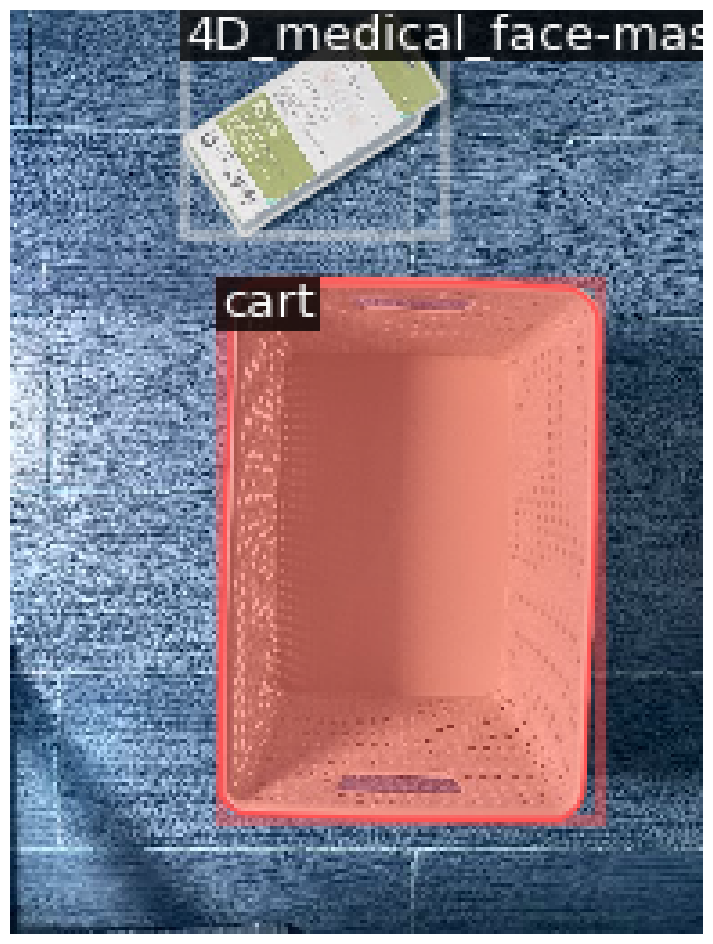

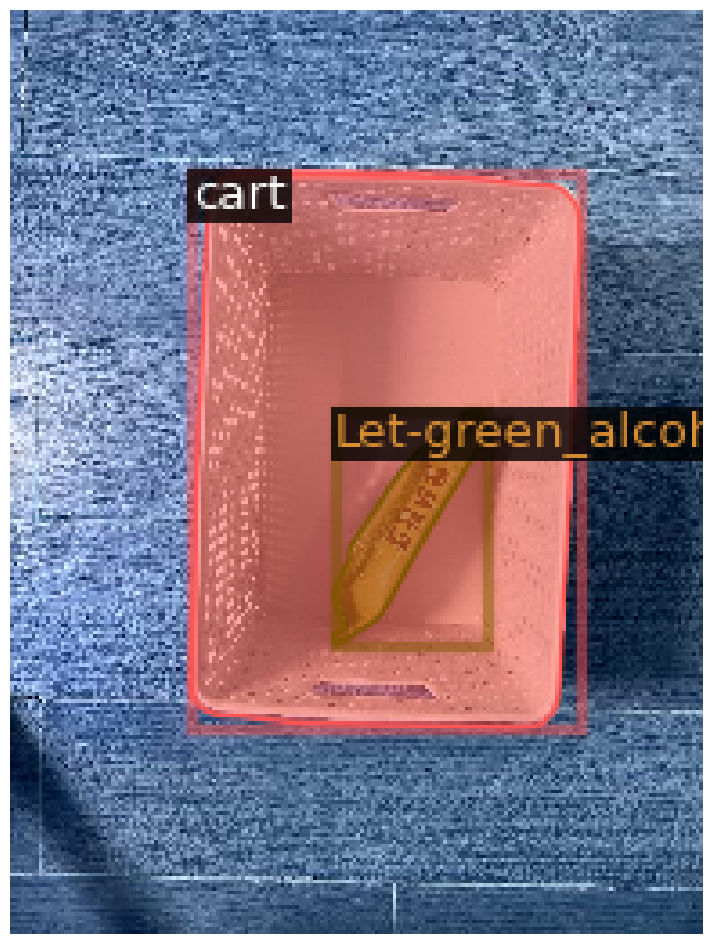

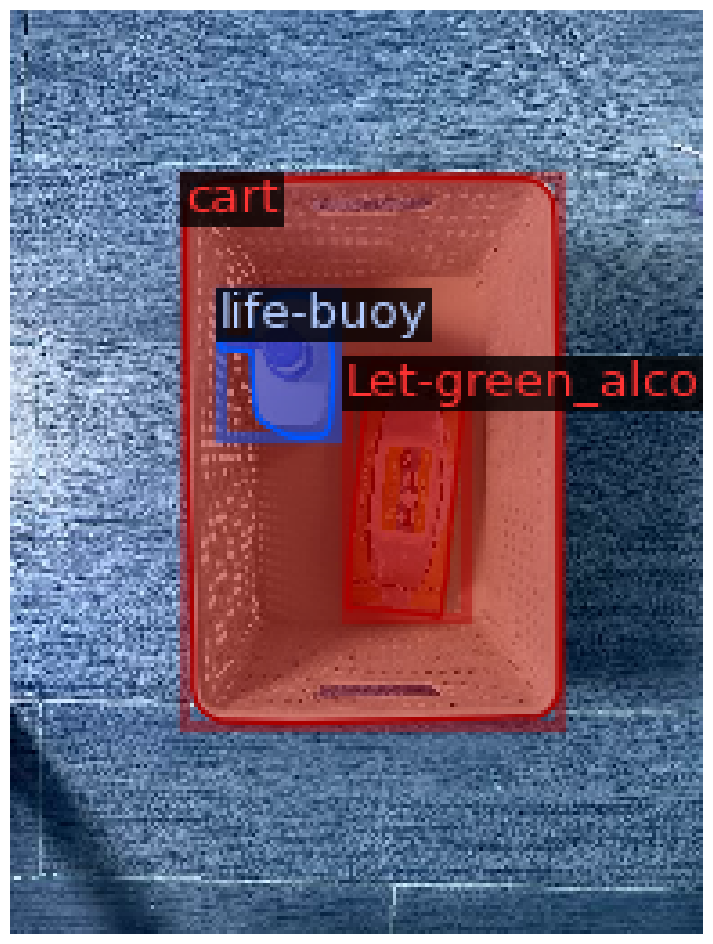

In [ ]:
import matplotlib.pyplot as plt

# Visualize 3 samples from the test data
dataset_dicts = DatasetCatalog.get("rpc_test")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=rpc_test_metadata, scale=0.4)
    vis = visualizer.draw_dataset_dict(d)

    # Use matplotlib to display the image
    plt.figure(figsize=(12, 12))
    plt.imshow(vis.get_image()[:, :, ::-1])  # Convert BGR to RGB
    plt.axis('off')  # Hide axis
    plt.show()


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("rpc_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 1500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # 128 images per batch
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10  # The RPC dataset contains 10 product categories

cfg.OUTPUT_DIR = "/content/drive/My Drive/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True) # The trained model and chekcpoints will be saved in the folder /content/drive/My Drive/output
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False) # Load weights from model zoo
trainer.train()

[10/26 09:49:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:01, 145MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[10/26 09:50:02 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/26 09:50:23 d2.utils.events]:  eta: 0:14:38  iter: 19  total_loss: 3.075  loss_cls: 2.439  loss_box_reg: 0.5603  loss_rpn_cls: 0.003048  loss_rpn_loc: 0.00216    time: 0.7692  last_time: 0.5933  data_time: 0.3215  last_data_time: 0.0016   lr: 4.9952e-05  max_mem: 3042M
[10/26 09:50:43 d2.utils.events]:  eta: 0:15:00  iter: 39  total_loss: 1.72  loss_cls: 1.096  loss_box_reg: 0.5156  loss_rpn_cls: 0.002854  loss_rpn_loc: 0.003153    time: 0.7749  last_time: 0.5066  data_time: 0.2507  last_data_time: 0.0017   lr: 9.9902e-05  max_mem: 3042M
[10/26 09:50:58 d2.utils.events]:  eta: 0:14:47  iter: 59  total_loss: 1.123  loss_cls: 0.5748  loss_box_reg: 0.5516  loss_rpn_cls: 0.001553  loss_rpn_loc: 0.003265    time: 0.7767  last_time: 0.5264  data_time: 0.2199  last_data_time: 0.0032   lr: 0.00014985  max_mem: 3042M
[10/26 09:51:13 d2.utils.events]:  eta: 0:14:53  iter: 79  total_loss: 1.082  loss_cls: 0.4835  loss_box_reg: 0.5772  loss_rpn_cls: 0.0003998  loss_rpn_loc: 0.002471    time: 0

In [ ]:
# Access the metadata for the dataset
metadata = MetadataCatalog.get("rpc_test")

# Print the number of categories
num_categories = len(metadata.thing_classes)
print(f"Number of categories: {num_categories}")

# Optionally, print the category names
print("Categories:", metadata.thing_classes)


Number of categories: 10
Categories: ['Er', '4D_medical_face-mask', 'Let-green_alcohol_wipes', 'X-men', 'aquafina', 'cart', 'life-buoy', 'luong_kho', 'milo', 'teppy_orange_juice']


In [ ]:
# Create Default Predictor
from detectron2.engine import DefaultTrainer,DefaultPredictor
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("rpc_train",)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10

cfg.MODEL.WEIGHTS = os.path.join('/content/drive/MyDrive/output','model_final.pth')

# cfg.MODEL.WEIGHTS = os.path.join(root_path,"smart_billing_model/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3    # NMS threshold
cfg.DATASETS.TEST = ("rpc_test", )
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
predictor = DefaultPredictor(cfg)


[10/26 10:09:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be e

[10/26 10:09:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/output/model_final.pth ...


In [ ]:
# Util function to display list of names of detected items
product_names = rpc_test_metadata.thing_classes
def create_list(instances):
  det_items = [product_names[i] for i in instances]
  return det_items

In [ ]:
import matplotlib.pyplot as plt

# Visualizing detections in images randomly sampled from the test set
dataset_dicts = DatasetCatalog.get("rpc_test")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)

    print(d["file_name"])

    # Use Visualizer to draw the instance predictions
    v = Visualizer(im[:, :, ::-1],
                   metadata=rpc_test_metadata,
                   scale=0.5)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Use matplotlib to display the image
    plt.figure(figsize=(12, 12))
    plt.imshow(v.get_image()[:, :, ::-1])  # Convert BGR to RGB
    plt.axis('off')  # Hide the axes
    plt.show()

    # Process detected items
    items = outputs["instances"].pred_classes.cpu().detach().numpy()
    items = list(items)
    print(create_list(items))


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict
from tabulate import tabulate
import random
import cv2

py_predictor = DefaultPredictor(cfg)

# Visualizing detections in images randomly sampled from the test set
dataset_dicts = DatasetCatalog.get("rpc_test")

# List of product names from the metadata
product_names = list(rpc_test_metadata.thing_classes)

# Function to create a list of detected instances based on predicted classes
def create_list(instances):
    det_items = [product_names[i] for i in instances]
    return det_items

# Function to print a bill of detected products with their quantities
def print_bill(instances):
    bill = defaultdict(int)
    for i in instances:
        bill[i] += 1
    l = []
    for key, value in bill.items():
        l.append([product_names[int(key)], value])
    # Create and print table using tabulate
    table = tabulate(l, headers=['Product Name', 'Quantity'], tablefmt='orgtbl')
    print(table)

# Iterate through random samples from the test set
for d in random.sample(dataset_dicts, 10):
    # Read the image
    im = cv2.imread(d["file_name"])

    print('\n')
    print(d["file_name"])

    # Get predictions from the model
    outputs = py_predictor(im)

    # Visualize the instance predictions
    v = Visualizer(im[:, :, ::-1], metadata=rpc_test_metadata, scale=1)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Display the image using matplotlib
    plt.figure(figsize=(30, 30))
    plt.imshow(v.get_image()[:, :, ::-1])  # Convert BGR to RGB
    plt.axis('off')  # Hide the axis
    plt.show()

    # Get the predicted class labels
    items = outputs["instances"].pred_classes.cpu().detach().numpy()
    items = list(items)

    # Print the predicted items and generate a bill
    print(items)
    print_bill(items)


Output hidden; open in https://colab.research.google.com to view.